In [ ]:
!pip install giotto-tda

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import gtda.images  
from skimage.feature import canny
import gtda.homology
import gtda.diagrams
import cv2 as cv
import tensorflow as tf
import skimage.exposure
from skimage.morphology import skeletonize

In [ ]:
fashion_mnist = tf.keras.datasets.fashion_mnist
(train_images, y_train), (test_images, y_test) = fashion_mnist.load_data()

In [ ]:
images = np.concatenate((train_images,test_images))

In [ ]:
conjugate_images = np.zeros((70000,28,28))
for i in range(0,70000):
  conjugate_images[i,:,:] =  255 - images[i,:,:]

In [ ]:
#%%plots image_dim*image_dim np array
def plot_image(Q):
    plt.matshow(Q);
    plt.colorbar()

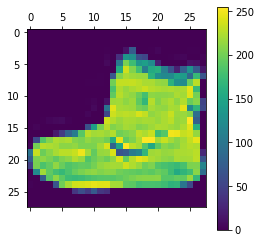

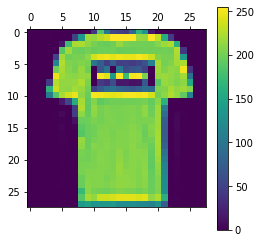

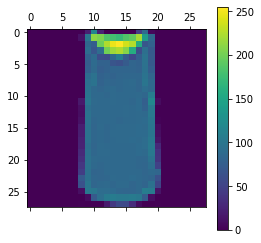

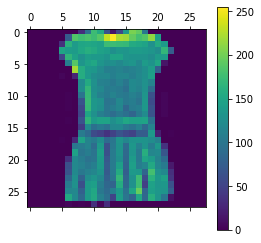

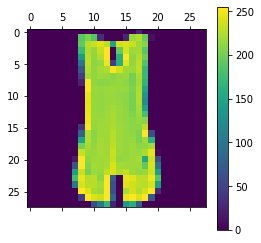

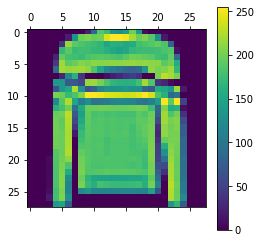

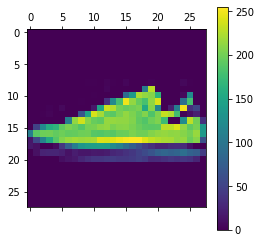

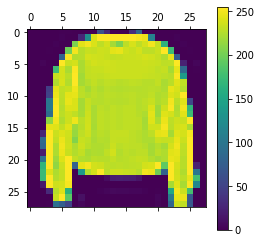

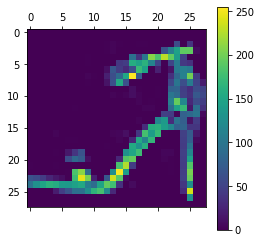

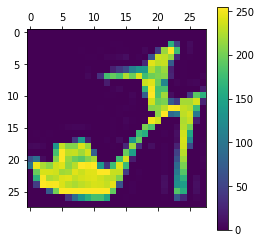

In [ ]:
for i in range(0,10):
  plot_image(images[i])

In [ ]:
size = 70000
hist_images = np.zeros((size,28,28))
hist_conjugate = np.zeros((size,28,28))
for i in range(0,size):
  hist_images[i,:,:] =  skimage.exposure.equalize_hist(images[i])*255
  hist_conjugate[i,:,:] =  255 - hist_images[i]

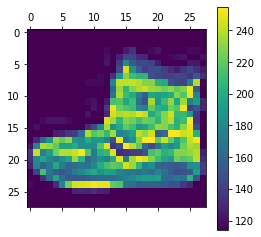

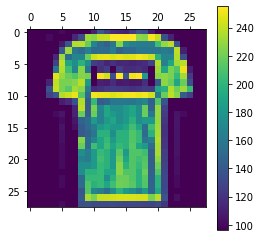

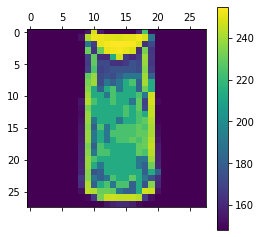

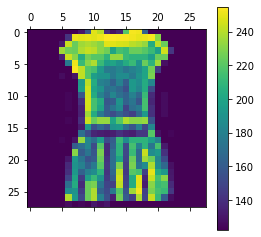

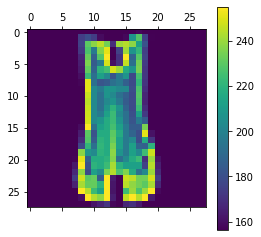

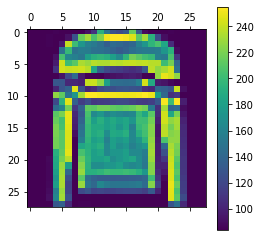

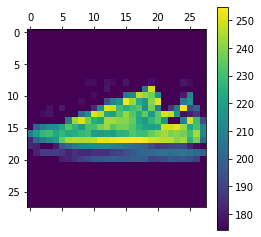

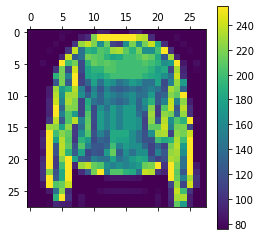

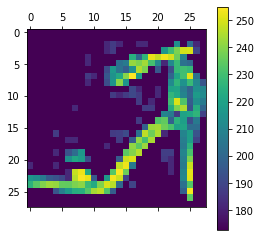

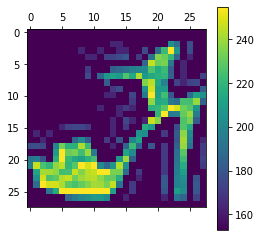

In [ ]:
for i in range(0,10):
  im = skimage.exposure.equalize_hist(images[i])*255
  plot_image(im)

In [ ]:
from skimage.filters import threshold_otsu

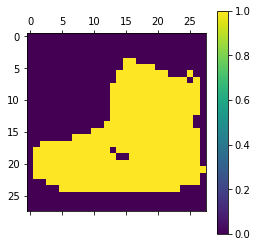

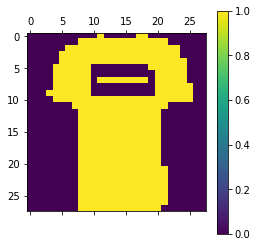

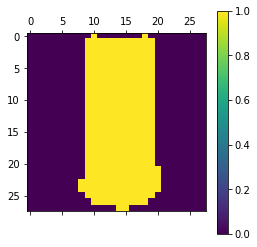

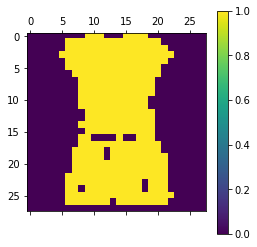

In [ ]:
for i in range(0,4):
  plot_image(binarized_images[i])

In [ ]:
binarized_images = np.zeros((70000,28,28))
for i in range(0,70000):
  global_thresh = threshold_otsu(images[i])
  bin_img = images[i] > global_thresh
  binarized_images[i] = bin_img

In [ ]:
height_array = [[1,0],[0,1],[1,1],[-1,1],[1,-1],[-1,-1],[-1,0],[0,-1]]

def height_data_fn(images = binarized_images, ht_array = height_array, ent=True, land=False, 
                   heat=False, wdist=False, betti=False):
    height_data = np.zeros((np.shape(images)[0],1))
    for i in range(0, np.shape(ht_array)[0]):
        height_fil_images = gtda.images.HeightFiltration(direction = np.array(ht_array[i])).fit_transform(images)
        cubical_diagrams = gtda.homology.CubicalPersistence(reduced_homology = False).fit_transform(height_fil_images)
        if ent == True:
            height_data = np.concatenate((height_data,gtda.diagrams.PersistenceEntropy().fit_transform(cubical_diagrams)), axis = 1)
        if land == True:
            height_data= np.concatenate((height_data,gtda.diagrams.Amplitude(metric_params={"n_layers":2} , metric ='landscape', 
                                                                             order = None).fit_transform(cubical_diagrams)), axis = 1)
        if heat == True:
            height_data = np.concatenate((height_data,gtda.diagrams.Amplitude(metric = 'heat', order = None).fit_transform(cubical_diagrams)),
                                         axis = 1)
        if betti == True:
            height_data = np.concatenate((height_data,gtda.diagrams.Amplitude(metric = 'betti', order = None).fit_transform(cubical_diagrams)),
                                         axis = 1)
        if wdist == True:
            height_data = np.concatenate((height_data,gtda.diagrams.Amplitude(metric = 'wasserstein', order = None).fit_transform(cubical_diagrams)),
                                         axis = 1)   
    print("done") 
    return height_data[:,1:]

In [ ]:
radial_array = [[6,6],[13,6],[20,6],[6,13],[13,13],[20,13],[6,20],[13,20],[20,20]]

def radial_data_fn(images = binarized_images, r_array = radial_array, ent=True, land=False, 
                   heat=False, wdist=False, betti=False):
    n_col = (2*ent + 2*land + 2*heat + 2*wdist +2*betti)*np.shape(r_array)[0]
    radial_data = np.zeros((np.shape(images)[0],n_col))
    m = 0 #current column counter
    for i in range(0, np.shape(r_array)[0]):
        radial_fil_images = gtda.images.RadialFiltration(center = np.array(r_array[i])).fit_transform(images)
        cubical_diagrams = gtda.homology.CubicalPersistence(reduced_homology = False).fit_transform(radial_fil_images)
        if ent == True:
            radial_data[:,m:m+2] = gtda.diagrams.PersistenceEntropy().fit_transform(cubical_diagrams)
            m = m + 2
        if land == True:
            radial_data[:,m:m+2] = gtda.diagrams.Amplitude(metric_params={"n_layers":2} , metric ='landscape', 
                                                           order = None).fit_transform(cubical_diagrams)
            m = m+2
        if heat == True:
            radial_data[:,m:m+2]= gtda.diagrams.Amplitude(metric = 'heat', order = None).fit_transform(cubical_diagrams)
            m = m + 2
        if betti == True:
            radial_data[:,m:m+2] = gtda.diagrams.Amplitude(metric = 'betti', order = None).fit_transform(cubical_diagrams)
            m = m + 2
        if wdist == True:
            radial_data[:,m:m+2] = gtda.diagrams.Amplitude(metric = 'wasserstein', order = None).fit_transform(cubical_diagrams)
            m = m + 2
    print("done")                       
    return radial_data


In [ ]:
density_array = [5,8,11]

def density_data_fn(images = binarized_images, d_array = density_array, ent=True, land=False, 
                    heat=False, wdist=False, betti=False):
    n_col = (2*ent + 2*land + 2*heat + 2*wdist +2*betti)*np.shape(d_array)[0]
    density_data = np.zeros((np.shape(images)[0],n_col))
    m = 0 #current column counter
    for i in range(0, np.shape(d_array)[0]):
        density_fil_images = gtda.images.DensityFiltration(radius = d_array[i]).fit_transform(images)
        cubical_diagrams = gtda.homology.CubicalPersistence(reduced_homology = False).fit_transform(density_fil_images)
        if ent == True:
            density_data[:,m:m+2] = gtda.diagrams.PersistenceEntropy().fit_transform(cubical_diagrams)
            m = m + 2
        if land == True:
            density_data[:,m:m+2] = gtda.diagrams.Amplitude(metric_params={"n_layers":2} , metric ='landscape', 
                                                           order = None).fit_transform(cubical_diagrams)
            m = m+2
        if heat == True:
            density_data[:,m:m+2]= gtda.diagrams.Amplitude(metric = 'heat', order = None).fit_transform(cubical_diagrams)
            m = m + 2
        if betti == True:
            density_data[:,m:m+2] = gtda.diagrams.Amplitude(metric = 'betti', order = None).fit_transform(cubical_diagrams)
            m = m + 2
        if wdist == True:
            density_data[:,m:m+2] = gtda.diagrams.Amplitude(metric = 'wasserstein', order = None).fit_transform(cubical_diagrams)
            m = m + 2
    print("done") 
    return density_data

In [ ]:
def grayscale_data_fn(images = images, ent=True, land=False, 
                      heat=False, wdist=False, betti=False):
    n_col = (2*ent + 2*land + 2*heat + 2*wdist +2*betti)
    grayscale_data = np.zeros((np.shape(images)[0],n_col))
    cubical_diagrams = gtda.homology.CubicalPersistence(reduced_homology = False).fit_transform(images)
    m=0
    if ent == True:
        grayscale_data[:,m:m+2] = gtda.diagrams.PersistenceEntropy().fit_transform(cubical_diagrams)
        m = m + 2
    if land == True:
        grayscale_data[:,m:m+2] = gtda.diagrams.Amplitude(metric_params={"n_layers":2} , metric ='landscape', 
                                                        order = None).fit_transform(cubical_diagrams)
        m = m + 2
    if heat == True:
        grayscale_data[:,m:m+2]= gtda.diagrams.Amplitude(metric = 'heat', order = None).fit_transform(cubical_diagrams)
        m = m + 2
    if betti == True:
        grayscale_data[:,m:m+2] = gtda.diagrams.Amplitude(metric = 'betti', order = None).fit_transform(cubical_diagrams)
        m = m + 2
    if wdist == True:
        grayscale_data[:,m:m+2] = gtda.diagrams.Amplitude(metric = 'wasserstein', order = None).fit_transform(cubical_diagrams)
        m = m + 2  
    print("done")          
    return grayscale_data

In [ ]:
def vr_data_fn(images = binarized_images, ent=True, land=False, 
               heat=False, wdist=False, betti=False):
    n_col = (2*ent + 2*land + 2*heat + 2*wdist +2*betti)
    vr_data = np.zeros((np.shape(images)[0],n_col))
    point_cloud_data = gtda.images.ImageToPointCloud().fit_transform(images)
    cubical_diagrams = gtda.homology.VietorisRipsPersistence(reduced_homology = False, infinity_values= 28.0).fit_transform(point_cloud_data)
    m=0
    if ent == True:
        vr_data[:,m:m+2] = gtda.diagrams.PersistenceEntropy().fit_transform(cubical_diagrams)
        m = m + 2
    if land == True:
        vr_data[:,m:m+2] = gtda.diagrams.Amplitude(metric_params={"n_layers":2}, metric ='landscape', 
                                                        order = None).fit_transform(cubical_diagrams)
        m = m + 2
    if heat == True:
        vr_data[:,m:m+2]= gtda.diagrams.Amplitude(metric = 'heat', order = None).fit_transform(cubical_diagrams)
        m = m + 2
    if betti == True:
        vr_data[:,m:m+2] = gtda.diagrams.Amplitude(metric = 'betti', order = None).fit_transform(cubical_diagrams)
        m = m + 2
    if wdist == True:
        vr_data[:,m:m+2] = gtda.diagrams.Amplitude(metric = 'wasserstein', order = None).fit_transform(cubical_diagrams)
        m = m + 2 
    print("done")           
    return vr_data

In [ ]:
def dilation_data(images = binarized_images, ent=True, land=False, 
                  heat=False, wdist=False, betti=False):
    n_col = (2*ent + 2*land + 2*heat + 2*wdist +2*betti)
    dil_data =  np.zeros((np.shape(images)[0],n_col))
    cubical_diagrams = gtda.homology.CubicalPersistence(reduced_homology = False).fit_transform(gtda.images.DilationFiltration().fit_transform(images))
    m=0
    if ent == True:
        dil_data[:,m:m+2] = gtda.diagrams.PersistenceEntropy().fit_transform(cubical_diagrams)
        m = m + 2
    if land == True:
        dil_data[:,m:m+2] = gtda.diagrams.Amplitude(metric_params={"n_layers":2} , metric ='landscape', 
                                                        order = None).fit_transform(cubical_diagrams)
        m = m + 2
    if heat == True:
        dil_data[:,m:m+2]= gtda.diagrams.Amplitude(metric = 'heat', order = None).fit_transform(cubical_diagrams)
        m = m + 2
    if betti == True:
        dil_data[:,m:m+2] = gtda.diagrams.Amplitude(metric = 'betti', order = None).fit_transform(cubical_diagrams)
        m = m + 2
    if wdist == True:
        dil_data[:,m:m+2] = gtda.diagrams.Amplitude(metric = 'wasserstein', order = None).fit_transform(cubical_diagrams)
        m = m + 2  
    print("done")          
    return dil_data

In [ ]:
def erosion_data_fn(images = binarized_images, ent=True, land=False, 
                    heat=False, wdist=False, betti=False):
    n_col = (2*ent + 2*land + 2*heat + 2*wdist +2*betti)
    erosion_data =  np.zeros((np.shape(images)[0],n_col))
    cubical_diagrams = gtda.homology.CubicalPersistence(reduced_homology = False).fit_transform(gtda.images.ErosionFiltration().fit_transform(images))
    m=0
    if ent == True:
        erosion_data[:,m:m+2] = gtda.diagrams.PersistenceEntropy().fit_transform(cubical_diagrams)
        m = m + 2
    if land == True:
        erosion_data[:,m:m+2] = gtda.diagrams.Amplitude(metric_params={"n_layers":2}, metric ='landscape', 
                                                        order = None).fit_transform(cubical_diagrams)
        m = m + 2
    if heat == True:
        erosion_data[:,m:m+2]= gtda.diagrams.Amplitude(metric = 'heat', order = None).fit_transform(cubical_diagrams)
        m = m + 2
    if betti == True:
        erosion_data[:,m:m+2] = gtda.diagrams.Amplitude(metric = 'betti', order = None).fit_transform(cubical_diagrams)
        m = m + 2
    if wdist == True:
        erosion_data[:,m:m+2] = gtda.diagrams.Amplitude(metric = 'wasserstein', order = None).fit_transform(cubical_diagrams)
        m = m + 2  
    print("done")         
    return erosion_data

In [ ]:
def sd_data_fn(images = binarized_images, ent=True, land=False, 
               heat=False, wdist=False, betti=False):
    n_col = (2*ent + 2*land + 2*heat + 2*wdist +2*betti)
    sd_data =  np.zeros((np.shape(images)[0],n_col))
    cubical_diagrams = gtda.homology.CubicalPersistence(reduced_homology = False).fit_transform(gtda.images.SignedDistanceFiltration().fit_transform(images))
    m=0
    if ent == True:
        sd_data[:,m:m+2] = gtda.diagrams.PersistenceEntropy().fit_transform(cubical_diagrams)
        m = m + 2
    if land == True:
        sd_data[:,m:m+2] = gtda.diagrams.Amplitude(metric_params={"n_layers":2}, metric ='landscape', 
                                                        order = None).fit_transform(cubical_diagrams)
        m = m + 2
    if heat == True:
        sd_data[:,m:m+2]= gtda.diagrams.Amplitude(metric = 'heat', order = None).fit_transform(cubical_diagrams)
        m = m + 2
    if betti == True:
        sd_data[:,m:m+2] = gtda.diagrams.Amplitude(metric = 'betti', order = None).fit_transform(cubical_diagrams)
        m = m + 2
    if wdist == True:
        sd_data[:,m:m+2] = gtda.diagrams.Amplitude(metric = 'wasserstein', order = None).fit_transform(cubical_diagrams)
        m = m + 2  
    print("done")          
    return sd_data

In [ ]:
# ax+by+c denotes line we are considering
def direction_filtration(Q,a,b,c, par = True):
    shape_x = np.shape(Q)[0]
    shape_y = np.shape(Q)[1]
    Qnew = np.zeros((shape_x,shape_y))
    for i in range(0,shape_x):
        for j in range(0,shape_y):
            if par and Q[i][j] == 1:
                Qnew[i][j] = abs(a*i + b*j + c)/((a**2 + b**2)**(1/2))
            if par != True and Q[i][j] == 1:
                Qnew[i][j] = -1 * abs(a*i + b*j + c)/((a**2 + b**2)**(1/2))
    max_val = np.max(Qnew)
    for i in range(0,shape_x):
        for j in range(0,shape_y):
            if Q[i][j] == 0:
                Qnew[i][j] = max_val+5
    return Qnew


In [ ]:
#line filtration corr to a,b,c for line of form ax+by+c = 0

def line_filtration(nparr, coeff, l):
    line_data = np.zeros((np.shape(coeff)[0],np.shape(nparr)[0],image_dim,image_dim))  
    for k in range(0,np.shape(nparr)[0]):
        for t in range(0,np.shape(coeff)[0]):
            line_data[t][k] = direction_filtration(binarized_images[k], a = coeff[t][0]
                                                   ,b = coeff[t][1]
                                                   ,c = coeff[t][2]
                                                   ,par = l[t])
    return line_data


In [ ]:
l = np.array((True, True, False, False))
coeff = [[1,-1,-20],[0,1,-27],[0,1,-13],[1,0,-13]]

def line_data_fn(images = binarized_images, ent=True, land=False, 
                 heat=False, wdist=False, betti=False):
    n_col = (2*ent + 2*land + 2*heat + 2*wdist +2*betti)*np.shape(coeff)[0]
    line_data =  np.zeros((np.shape(images)[0],n_col))
    line_fil_images = line_filtration(images,coeff, l)
    m = 0 #current column counter
    for i in range(0, np.shape(coeff)[0]):
        cubical_diagrams = gtda.homology.CubicalPersistence(reduced_homology = False).fit_transform(line_fil_images[i])
        if ent == True:
            line_data[:,m:m+2] = gtda.diagrams.PersistenceEntropy().fit_transform(cubical_diagrams)
            m = m + 2
        if land == True:
            line_data[:,m:m+2] = gtda.diagrams.Amplitude(metric_params={"n_layers":2}, metric ='landscape', 
                                                           order = None).fit_transform(cubical_diagrams)
            m = m+2
        if heat == True:
            line_data[:,m:m+2]= gtda.diagrams.Amplitude(metric = 'heat', order = None).fit_transform(cubical_diagrams)
            m = m + 2
        if betti == True:
            line_data[:,m:m+2] = gtda.diagrams.Amplitude(metric = 'betti', order = None).fit_transform(cubical_diagrams)
            m = m + 2
        if wdist == True:
            line_data[:,m:m+2] = gtda.diagrams.Amplitude(metric = 'wasserstein', order = None).fit_transform(cubical_diagrams)
            m = m + 2     
    print("done") 
    return line_data

In [ ]:
height_data = height_data_fn(images = binarized_images, ent = True, land = True, wdist = True, betti = True)
pd.DataFrame(height_data).to_csv('height_data.csv')
density_data = density_data_fn(images = binarized_images, ent = True, land = True, wdist = True, betti = True)
pd.DataFrame(density_data).to_csv('density_data.csv')
radial_data = radial_data_fn(images = binarized_images, ent = True, land = True, wdist = True, betti = True)
pd.DataFrame(radial_data).to_csv('radial_data.csv')

done
done
done


In [ ]:
image_dim = 28
!zip Pipeline_Fashion.zip *.csv
!mv Pipeline_Fashion.zip "/content/drive/My Drive"

  adding: density_data.csv (deflated 60%)
  adding: height_data.csv (deflated 66%)
  adding: radial_data.csv (deflated 64%)
mv: cannot stat 'Pipeline_Fashion': No such file or directory


In [ ]:
line_data = line_data_fn(images = binarized_images, ent = True, land = True, wdist = True, betti = True)
pd.DataFrame(line_data).to_csv('line_data.csv')

#vr_data = vr_data_fn(images = binarized_images, ent = True)
#pd.DataFrame(vr_data).to_csv('vr_data.csv')

In [ ]:
grayscale_data = []
conjugate_data = []
for i in range(0,70000,5000):
  images_1 = images[i:i+5000]
  conjugate_images_1 = conjugate_images[i:i+5000]
  grayscale_data = grayscale_data + list(grayscale_data_fn(images = images_1, ent = True, wdist = True, land = True, betti = True))
  pd.DataFrame(grayscale_data).to_csv('grayscale_data.csv')
  conjugate_data = conjugate_data + list(grayscale_data_fn(images = conjugate_images_1, ent = True, wdist = True, land = True, betti = True))
  pd.DataFrame(conjugate_data).to_csv('conjugate_data.csv')

In [ ]:
!zip Pipeline_Fashion_1.zip *.csv
!mv Pipeline_Fashion_1.zip "/content/drive/My Drive"

  adding: conjugate_data.csv (deflated 53%)
  adding: grayscale_data.csv (deflated 52%)


In [ ]:
!unzip "/content/drive/My Drive/Pipeline_Fashion_1.zip"
!unzip "/content/drive/My Drive/Pipeline_Fashion.zip"

In [ ]:
import numpy as np
import pandas as pd
from sklearn import preprocessing
from sklearn.ensemble import RandomForestClassifier
from sklearn import metrics

In [ ]:
height_data = (pd.read_csv("height_data.csv")).iloc[:,1:]
density_data = (pd.read_csv("density_data.csv")).iloc[:,1:]
radial_data = (pd.read_csv("radial_data.csv")).iloc[:,1:]
line_data = (pd.read_csv("line_data.csv")).iloc[:,1:]
grayscale_data = (pd.read_csv("grayscale_data.csv")).iloc[:,1:]
conjugate_data = (pd.read_csv("conjugate_data.csv")).iloc[:,1:]

data = pd.concat([height_data,density_data,radial_data,line_data,grayscale_data,conjugate_data], axis = 1)
train_data = data.iloc[:60000,]
test_data = data.iloc[60000:,]

In [ ]:
classifier = RandomForestClassifier(n_estimators = 1000, random_state = 31415)
classifier.fit(train_data, y_train)

RandomForestClassifier(n_estimators=1000, random_state=31415)

In [ ]:
pred = classifier.predict(test_data)
accuracy = classifier.score(test_data, y_test)
print(accuracy*100)

85.02


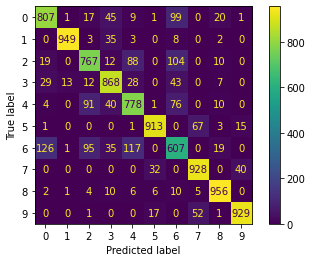

In [ ]:
from sklearn.metrics import plot_confusion_matrix
plot_confusion_matrix(classifier, test_data, y_test) 

In [ ]:
pd.DataFrame(y_train).iloc[:25]

,0
0,9
1,0
2,0
3,3
4,0
5,2
6,7
7,2
8,5
9,5


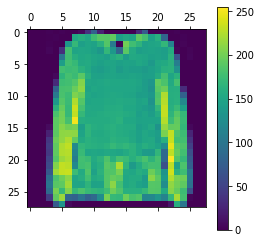

In [ ]:
plot_image(images[18])

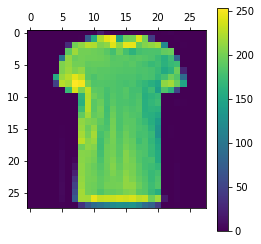

In [ ]:
plot_image(images[17])